<a href="https://colab.research.google.com/github/mickeymou5e/PredictingCarryTradeSecurities/blob/Calculation/Big_data_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1.**

This Project is an Applied Trading Strategy using Currency Carry Trades. 

## **Currency Carry Trade**

A currency carry trade is an investment strategy in which an investor takes advantage of the interest rate spread of two countries to generate excess profit (Eun & Resnick, 2011). The underlying concept of the carry trade involves buying the high interest-bearing asset and selling the low interest-bearing one, profiting on the difference. Nonetheless, under the assumptions of perfect capital mobility and substitutable riskiness and liquidity (Madura, 2007), such investment opportunities should follow a no-arbitrage condition and therefore, investors should be indifferent between which interest-bearing instrument they purchase. This no–arbitrage condition is also known as Interest rate parity. 


# **Forward Premium Puzzle**

Hansen and Hodrick (1980) were among the first researchers who investigated the relationship between exchange rates and interest rate specifically using a large data sample. Their findings show a systematic violation of the uncovered interest rate parity. This relates directly to the previous paragraph as it suggests that excess profits on currency trades can be made. In 1984, Fama investigated the relationship between exchange rates and interest rates further. Fama not only found a violation of the no-arbitrage clause, but he also found that countries that have higher interest rates tend to have their currency appreciate instead of depreciate against the lower interest rate currencies. Fama coined the term Forward Premium puzzle for this phenomenon.  The violations of uncovered Interest rate parity have only become more egregious since the 2008 financial crisis (Du et al., 2018), potentially creating more profitable trading opportunities.



In [2]:
!pip install yfinance
!pip install --user xgboost
#$ conda install -c conda-forge py-xgboost-cpu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [3]:
import pandas as pd 
import numpy as np 
import os 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() 
import functools as ft
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

# **Part 2**

# **Big Data Project**

We have established and shown what a Currency Carry Trade is and provided an example of how one can profit from such trades. Many variables that can affect the returns of carry trades exist. These range from using bonds with different maturities to using different currencies. In this project, we will try to identify the best currencies to use to construct trades.

This project aims to serve as a proof of concept, for selecting both the seed and the investing currencies. The rationale is the following:

**i.** Two seed currencies and two investing currencies are selected from the universe of currencies. In the case of this project we have selected Euro and the Yen as seed currencies due to their low yield. The two investing currencies we have selected are the United States Dollar and the Australian Dollar. These currencies have been selected specifically due to their higher I/R. All the currencies were also chosen due to being from developed G20 countries, who's data is readily available for no cost.

**ii.** Using these currencies, we will compute the return of Uncovered Currency Carry Trades, and we will calculate the highest returning currency pair for every period.

**iii.** Once we have identified the best performing currencies for carry trades, we use Gradient Boosted Decision Trees to train and test models for predicting which seed and investing currency will have the highest return in any given time period.

Lastly, we will evaluate the model.

# **Accessing Data**

**1.** In the first step of this project we need to import all the data for the exchange rate and interest rates but also other features. In the below cell, we access the yahoo API and use it to download E/R and Vix data.

**2.** We use fyahoo library and the get_data_yahoo method to access the API and then loop over the list of heading in list_of_Data to download the data into a dictionary dict_of_ER().

**3.** We then create df_ER by passing a dictionary to a merge function.

**4.** Finally, we rename the columns to make the data more legible.


In [17]:
start_date= "2002-04-01"
end_date="2023-01-01"

list_of_Data = ["^VIX","EURUSD=X","JPY=X","AUDUSD=X"]
dict_of_ER = {}

def GetER(ticker):
    dict_of_ER["df_{}".format(ticker)] = pdr.get_data_yahoo("{}".format(ticker), start=start_date, end=end_date)[["Close"]]
    dict_of_ER["df_{}".format(ticker)].rename(columns={"Close": "Close {}".format(ticker)},inplace = True)

for i in list_of_Data:
  GetER(i)

df_ER = ft.reduce(lambda left, right: pd.merge(left, right, on='Date'), [v for v in dict_of_ER.values()])

df_ER.rename(columns={"Close ^VIX": "VIX", "Close EURUSD=X": "EURUSD","Close JPY=X": "JPYUSD", "Close AUDUSD=X": "AUDUSD"},inplace = True)
df_ER.columns

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Index(['VIX', 'EURUSD', 'JPYUSD', 'AUDUSD'], dtype='object')

In [18]:
df_ER.head()

,VIX,EURUSD,JPYUSD,AUDUSD
Date,,,,
2006-05-16,13.350000,1.285000,109.760002,0.767106
2006-05-17,16.260000,1.274194,110.910004,0.759417
2006-05-18,16.990000,1.285099,110.900002,0.764000
2006-05-19,17.180000,1.276699,111.660004,0.757174
2006-05-22,17.719999,1.285298,111.459999,0.753409


**5.** We have download 3 E/R's and now they can be used to compute specific unquoted exchange rates (most exchange rates are dollar denominated only and specific pairs need to be calculated). We thus take the EUR/USD exchange rate and divide by the AUD/USD exchange rate to get the EUR/AUD exchange rate. 


In [19]:
df_ER["EURAUD"] = df_ER["EURUSD"]/df_ER["AUDUSD"]
df_ER["JPYAUD"] = df_ER["JPYUSD"]/df_ER["AUDUSD"]
df_ER.head()

,VIX,EURUSD,JPYUSD,AUDUSD,EURAUD,JPYAUD
Date,,,,,,
2006-05-16,13.350000,1.285000,109.760002,0.767106,1.675126,143.083139
2006-05-17,16.260000,1.274194,110.910004,0.759417,1.677858,146.046295
2006-05-18,16.990000,1.285099,110.900002,0.764000,1.682066,145.157014
2006-05-19,17.180000,1.276699,111.660004,0.757174,1.686136,147.469373
2006-05-22,17.719999,1.285298,111.459999,0.753409,1.705975,147.940851


# **Interest Rate Differential Calculation**

**6.** In this step, we access the Interest Rate data. This data has been downloaded from FRED, and contains the returns of the 3 month T-Bills of the allotted countries

In [20]:
listOfIR = ["AUD_IB3MR.csv","EUR_IB3MR.csv","JPY_IB3MR.csv","USD_IB3MR.csv"]

dict_of_IR ={}

def GetIR(ticker):

  dict_of_IR["df_{}".format(ticker)] = pd.read_csv(ticker)

for i in listOfIR:
  GetIR(i)

**7.** Some of the data frame DATE columns have issues with monotonicity and as such the Data column is set from one of the data frame such that they match. 

In [21]:
dict_of_IR["df_USD_IB3MR.csv"]["DATE"] =  dict_of_IR["df_EUR_IB3MR.csv"]["DATE"]
dict_of_IR["df_AUD_IB3MR.csv"]["DATE"] =  dict_of_IR["df_EUR_IB3MR.csv"]["DATE"]
dict_of_IR["df_JPY_IB3MR.csv"]["DATE"] =  dict_of_IR["df_EUR_IB3MR.csv"]["DATE"]

**8.** All the I/R in the dictionary of interest rates are merged into a data frame called df_IR and the head of the Data frame is returned. The columns are also renamed. 

In [22]:
df_IR = ft.reduce(lambda left, right: pd.merge(left, right, on='DATE'), [v for v in dict_of_IR.values()])
df_IR.rename(columns={"IR3TIB01AUM156N": "AUIR", "IR3TIB01EZM156N": "EUIR","IR3TIB01JPM156N": "JPIR", "IR3TIB01USM156N": "USIR"},inplace = True)
df_IR.head()

,DATE,AUIR,EUIR,JPIR,USIR
0,2002-04-01,4.59,3.4069,0.10,1.87
1,2002-05-01,4.84,3.4671,0.08,1.82
2,2002-06-01,5.07,3.4640,0.09,1.81
3,2002-07-01,4.98,3.4100,0.09,1.79
4,2002-08-01,4.96,3.3519,0.07,1.73


**9.** Since our Interest Rates have yearly returns, and we don't want to be dealing with rolling our positions, it's easier to just calculate the Interest on a 3-month Basis and Construct the carry trades for a 3-month period. 

In [23]:
#As previously normalizing the data so we can use log normal returns (because they are symmetric)
df_IR.iloc[:,1:] = (df_IR.iloc[:,1:]/100 + 1)**(0.25)
df_IR.head()

,DATE,AUIR,EUIR,JPIR,USIR
0,2002-04-01,1.011283,1.008411,1.000250,1.004643
1,2002-05-01,1.011886,1.008557,1.000200,1.004519
2,2002-06-01,1.012441,1.008550,1.000225,1.004495
3,2002-07-01,1.012224,1.008418,1.000225,1.004445
4,2002-08-01,1.012176,1.008276,1.000175,1.004297


**10.** Here we define a function to calculate the Interest Rate differential between two countries. You are always selling the low yielding currency and buying the high yielding so the carry will be either zero or positive. 

In [24]:
#Interest Rate Differntials 
def IRD(df,currency1,currency2):
  df["{}{}IRD".format(currency1[:2],currency2[:2])] = np.where(df[currency1] >  df[currency2],
                                         (np.log(df[currency1]) - np.log(df[currency2])),np.log(df[currency2]-(np.log(df[currency1]))))

IRD(df_IR,"AUIR","JPIR")
IRD(df_IR,"AUIR","EUIR")
IRD(df_IR,"USIR","JPIR")
IRD(df_IR,"USIR","EUIR")

In [25]:
df_IR.head()

,DATE,AUIR,EUIR,JPIR,USIR,AUJPIRD,AUEUIRD,USJPIRD,USEUIRD
0,2002-04-01,1.011283,1.008411,1.000250,1.004643,0.010970,0.002844,0.004382,0.003772
1,2002-05-01,1.011886,1.008557,1.000200,1.004519,0.011616,0.003295,0.004309,0.004040
2,2002-06-01,1.012441,1.008550,1.000225,1.004495,0.012139,0.003851,0.004260,0.004057
3,2002-07-01,1.012224,1.008418,1.000225,1.004445,0.011925,0.003767,0.004211,0.003975
4,2002-08-01,1.012176,1.008276,1.000175,1.004297,0.011927,0.003860,0.004113,0.003980


# **Reindexing**

**11.** Looking at the data, we realize the fact that some dates are missing. This is because the data we have are only available for trading days. This, however, makes calculating rolling returns very awkward. As such, we need to re-index the data frame and fill with the previous value at every step. To do this I created an DF Object as It's just so much faster and cleaner, than both using functions and or hard coding it. 


In [26]:
class DataFrameObj:
  def __init__(self,df):
    self.df = df 
  
  def SetDateasIDX(self,dateColumn):
      self.df.index = self.df[dateColumn]
      del self.df[dateColumn]

  def reindexDataframe(self,**kwargs):
    self.df.index = pd.to_datetime(self.df.index,**kwargs)
    self.df.index.date
    self.idx = pd.date_range(self.df.index[0], self.df.index[-1]) 
    self.df.index.date
    self.df = self.df.reindex(self.idx, method= "ffill") 

In [27]:
df_temp = DataFrameObj(df_IR)
df_temp.SetDateasIDX("DATE")
df_temp.reindexDataframe()
df_IR = df_temp.df
df_IR.head()

,AUIR,EUIR,JPIR,USIR,AUJPIRD,AUEUIRD,USJPIRD,USEUIRD
2002-04-01,1.011283,1.008411,1.00025,1.004643,0.01097,0.002844,0.004382,0.003772
2002-04-02,1.011283,1.008411,1.00025,1.004643,0.01097,0.002844,0.004382,0.003772
2002-04-03,1.011283,1.008411,1.00025,1.004643,0.01097,0.002844,0.004382,0.003772
2002-04-04,1.011283,1.008411,1.00025,1.004643,0.01097,0.002844,0.004382,0.003772
2002-04-05,1.011283,1.008411,1.00025,1.004643,0.01097,0.002844,0.004382,0.003772


In [28]:
df_temp = DataFrameObj(df_ER)
df_temp.reindexDataframe()
df_ER = df_temp.df
df_ER.head()

,VIX,EURUSD,JPYUSD,AUDUSD,EURAUD,JPYAUD
2006-05-16,13.35,1.285000,109.760002,0.767106,1.675126,143.083139
2006-05-17,16.26,1.274194,110.910004,0.759417,1.677858,146.046295
2006-05-18,16.99,1.285099,110.900002,0.764000,1.682066,145.157014
2006-05-19,17.18,1.276699,111.660004,0.757174,1.686136,147.469373
2006-05-20,17.18,1.276699,111.660004,0.757174,1.686136,147.469373


# **Features** 
 
**12.** Adding in features including: Inflation, Level of Equities Index and Money Supply. These were collected from OECD.org

**13.** Much like the previous example the data is monthly, so we need to re-index, using our DF object this is very quick, neat and easy. 

In [29]:
extraFeaturesDf = pd.read_csv("Extra_Features_Big_data.csv",sep = ';')
extraFeaturesDf.head()

,TIME,JPN_inflation,USA_inflation,OECD_inflation,EU19_inflation,AUS_shareprice,CAN_shareprice,JPN_shareprice,USA_shareprice,EU19_shareprice,AUS_m1,JPN_m1,USA_m1,OECD_m1,EA19_m1
0,Jan-93,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263
1,Feb-93,1.4,3.246753,4.780497,1.8,28.99640,24.07189,83.41331,24.10519,29.99915,8.760245,25.08415,34.20213,15.20865,18.00406
2,Mar-93,1.2,3.086863,4.646151,1.7,30.29091,25.12321,87.79287,24.57130,31.13988,8.906493,25.13989,34.36429,15.32410,17.95495
3,Apr-93,0.9,3.225806,4.631979,1.6,30.85897,26.42713,100.34170,24.23496,31.12180,9.045428,25.27317,34.66875,15.46957,18.04393
4,May-93,0.9,3.221188,4.657243,1.8,30.89174,27.07759,104.40150,24.36321,30.74761,9.169739,25.60391,35.27436,15.76097,18.17636


In [30]:
df_temp = DataFrameObj(extraFeaturesDf)
df_temp.SetDateasIDX("TIME")
df_temp.reindexDataframe(format = "%b-%y")
extraFeaturesDf = df_temp.df
extraFeaturesDf.head()

,JPN_inflation,USA_inflation,OECD_inflation,EU19_inflation,AUS_shareprice,CAN_shareprice,JPN_shareprice,USA_shareprice,EU19_shareprice,AUS_m1,JPN_m1,USA_m1,OECD_m1,EA19_m1
1993-01-01,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263
1993-01-02,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263
1993-01-03,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263
1993-01-04,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263
1993-01-05,1.3,3.258508,4.811675,1.6,27.97681,23.05216,82.36322,23.73477,28.30943,8.613997,25.06713,34.09954,15.09149,18.68263


## **Merging**

In [31]:
df_total = df_ER.merge(df_IR, left_index=True, right_index=True)
df_total = df_total.merge(extraFeaturesDf, left_index=True, right_index=True)
df_total.head(-5)

,VIX,EURUSD,JPYUSD,AUDUSD,EURAUD,JPYAUD,AUIR,EUIR,JPIR,USIR,...,AUS_shareprice,CAN_shareprice,JPN_shareprice,USA_shareprice,EU19_shareprice,AUS_m1,JPN_m1,USA_m1,OECD_m1,EA19_m1
2006-05-16,13.350000,1.285000,109.760002,0.767106,1.675126,143.083139,1.014363,1.007146,1.000674,1.012634,...,94.37208,83.03589,107.5002,78.19043,98.74023,41.76107,78.54222,45.9073,46.7822,56.12231
2006-05-17,16.260000,1.274194,110.910004,0.759417,1.677858,146.046295,1.014363,1.007146,1.000674,1.012634,...,94.37208,83.03589,107.5002,78.19043,98.74023,41.76107,78.54222,45.9073,46.7822,56.12231
2006-05-18,16.990000,1.285099,110.900002,0.764000,1.682066,145.157014,1.014363,1.007146,1.000674,1.012634,...,94.37208,83.03589,107.5002,78.19043,98.74023,41.76107,78.54222,45.9073,46.7822,56.12231
2006-05-19,17.180000,1.276699,111.660004,0.757174,1.686136,147.469373,1.014363,1.007146,1.000674,1.012634,...,94.37208,83.03589,107.5002,78.19043,98.74023,41.76107,78.54222,45.9073,46.7822,56.12231
2006-05-20,17.180000,1.276699,111.660004,0.757174,1.686136,147.469373,1.014363,1.007146,1.000674,1.012634,...,94.37208,83.03589,107.5002,78.19043,98.74023,41.76107,78.54222,45.9073,46.7822,56.12231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22,21.290001,1.024569,142.098007,0.660780,1.550545,215.045862,1.007564,1.004532,0.999960,1.010968,...,129.30730,138.85640,126.8434,142.09090,116.27600,240.65080,169.14620,659.7454,466.5993,182.05620
2022-11-23,20.350000,1.031109,141.154999,0.664982,1.550581,212.268895,1.007564,1.004532,0.999960,1.010968,...,129.30730,138.85640,126.8434,142.09090,116.27600,240.65080,169.14620,659.7454,466.5993,182.05620
2022-11-24,20.350000,1.031109,141.154999,0.664982,1.550581,212.268895,1.007564,1.004532,0.999960,1.010968,...,129.30730,138.85640,126.8434,142.09090,116.27600,240.65080,169.14620,659.7454,466.5993,182.05620
2022-11-25,20.500000,1.040810,138.602997,0.676560,1.538386,204.864368,1.007564,1.004532,0.999960,1.010968,...,129.30730,138.85640,126.8434,142.09090,116.27600,240.65080,169.14620,659.7454,466.5993,182.05620


# **Calculating Currency Carry Trade Returns**

**14.**  The formula for calculating Carry Trade excess returns can be expressed in logarithms as the following: 

  𝚬(R<sub>t+1</sub>) =  *ln*(1+R<sub>t,Foreign</sub>) - *ln*(1+R<sub>t,Domestic</sub>) - (*ln*(S<sub>t+1</sub>) - *ln*(S<sub>t</sub>))

  Where Rt Foreign is the Foreign Interest Rate, Rt Domestic is the Domestic Interest Rate and St and St+1 is the current and future interest rate denominated as foreign currency  per one unit of domestic currency. 


In [32]:
df_total["JPYAUDerd"] = np.where(df_total["JPIR"] >  df_total["AUIR"],(np.log(df_total["JPYAUD"].shift(-91))-np.log(df_total["JPYAUD"])),-(np.log(df_total["JPYAUD"].shift(-91))-np.log(df_total["JPYAUD"])))
df_total["USDEURerd"] = np.where(df_total["EUIR"] >  df_total["USIR"],(np.log(df_total["EURUSD"].shift(-91))-np.log(df_total["EURUSD"])),-(np.log(df_total["EURUSD"].shift(-91))-np.log(df_total["EURUSD"])))
df_total["JPYUSDeer"] = np.where(df_total["JPIR"] >  df_total["USIR"],(np.log(df_total["JPYUSD"].shift(-91))-np.log(df_total["JPYUSD"])),-(np.log(df_total["JPYUSD"].shift(-91))-np.log(df_total["JPYUSD"])))
df_total["AUDEUReer"] = np.where(df_total["AUIR"] >  df_total["EUIR"],(np.log(df_total["EURAUD"].shift(-91))-np.log(df_total["EURAUD"])),-(np.log(df_total["EURAUD"].shift(-91))-np.log(df_total["EURAUD"])))

df_total["CarryJPYAUD"] = df_total["AUJPIRD"] - df_total["JPYAUDerd"]
df_total["CarryUSDEUR"] = df_total["USEUIRD"] - df_total["USDEURerd"] 
df_total["CarryJPYUSD"] = df_total["USJPIRD"] - df_total["JPYUSDeer"]
df_total["CarryAUDEUR"] = df_total["AUEUIRD"] - df_total["AUDEUReer"]

listCarryReturns = ["CarryJPYAUD","CarryUSDEUR","CarryJPYUSD","CarryAUDEUR"]

for i in listCarryReturns:
  df_total[i] = ((df_total[i]+1)**4)-1

# **Histogram of Carry Trade Returns**

**15.** In the below chart, we can see the returns of a 1-year Carry Trade using the currency pairs of USD and EUR. We can see that the median return was around 0 at and the mean at about 8%. The mean is highlighted by the blue line. The returns also approximately follow a normal distribution with a slight positive skew, this is shown by the KDE line.  

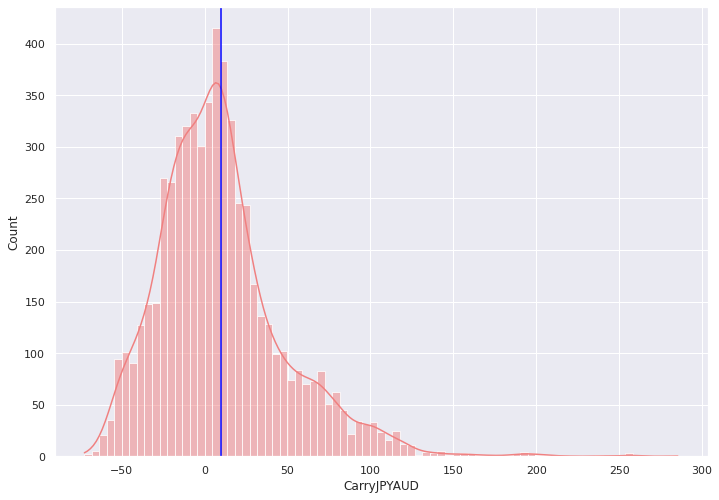

In [33]:
#3 Month Returns Annualized as a % for JPY and AUD 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_total["CarryJPYAUD"]*100,color = "lightcoral",kde = True)
plt.axvline(x=df_total["CarryJPYAUD"].mean()*100, color='blue',label = "Mean")

In [34]:
df_total["CarryJPYAUD"].mean()*100

9.618575678136535

In [35]:
df_total.loc[df_total["CarryAUDEUR"].idxmax()]

VIX                 57.529999
EURUSD               1.495707
JPYUSD             110.089996
AUDUSD               0.670017
EURAUD               2.232343
JPYAUD             164.309316
AUIR                 1.014746
EUIR                 1.012545
JPIR                 1.002218
USIR                 1.010629
AUJPIRD              0.012423
AUEUIRD              0.002171
USJPIRD              0.008358
USEUIRD              0.001970
JPN_inflation        1.700000
USA_inflation        3.655186
OECD_inflation       3.791110
EU19_inflation       1.200000
AUS_shareprice      76.622150
CAN_shareprice      67.949300
JPN_shareprice      58.681780
USA_shareprice      57.415630
EU19_shareprice     67.804340
AUS_m1              52.473720
JPN_m1              77.566390
USA_m1              48.773200
OECD_m1             52.139120
EA19_m1             61.942870
JPYAUDerd            0.230499
USDEURerd           -0.094306
JPYUSDeer            0.172145
AUDEUReer           -0.152660
CarryJPYAUD         -0.626184
CarryUSDEU

In [36]:
df_total.loc['2009-01-08']

VIX                 42.560001
EURUSD               1.369901
JPYUSD              91.360001
AUDUSD               0.711997
EURAUD               1.924025
JPYAUD             128.315121
AUIR                 1.009222
EUIR                 1.006085
JPIR                 1.001795
USIR                 1.002540
AUJPIRD              0.007386
AUEUIRD              0.003112
USJPIRD              0.000744
USEUIRD              0.003542
JPN_inflation        0.000000
USA_inflation        0.029847
OECD_inflation       1.369479
EU19_inflation       1.600000
AUS_shareprice      65.270520
CAN_shareprice      62.020400
JPN_shareprice      53.172850
USA_shareprice      51.378470
EU19_shareprice     60.492070
AUS_m1              56.912340
JPN_m1              77.900270
USA_m1              52.380390
OECD_m1             54.685020
EA19_m1             64.401180
JPYAUDerd           -0.085166
USDEURerd           -0.040143
JPYUSDeer           -0.094753
AUDEUReer           -0.049730
CarryJPYAUD          0.424848
CarryUSDEU

**16.** Finding Higest Performing Currency Pairs

In [37]:
df_total['Maximum'] = df_total[['CarryJPYAUD','CarryUSDEUR',"CarryJPYUSD","CarryAUDEUR"]].idxmax(axis=1)
df_total['Maximum']



2006-05-16    CarryJPYAUD
2006-05-17    CarryJPYUSD
2006-05-18    CarryJPYAUD
2006-05-19    CarryJPYUSD
2006-05-20    CarryJPYUSD
                 ...     
2022-11-27            NaN
2022-11-28            NaN
2022-11-29            NaN
2022-11-30            NaN
2022-12-01            NaN
Freq: D, Name: Maximum, Length: 6044, dtype: object

In [38]:
df_total = df_total.dropna()

**17.** Number of periods(days) a currency pair yielded the highest performing carry trade

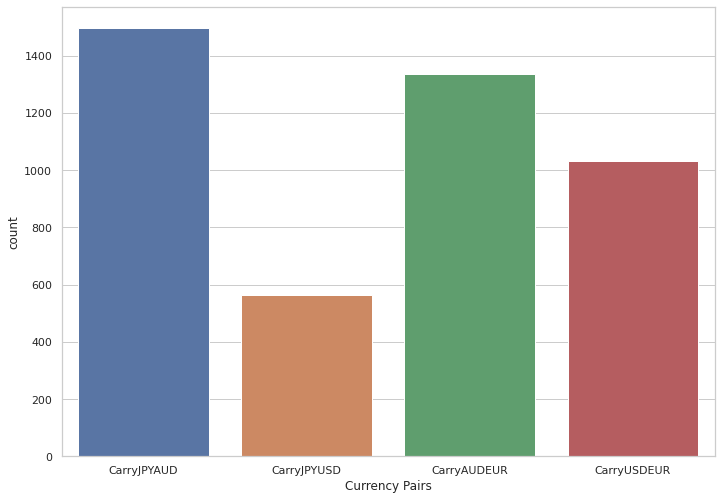

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
with sns.axes_style("whitegrid"):
  sns.countplot(x='Maximum', data=df_total)
  plt.xlabel('Currency Pairs')


# **Prediciting the best performing Currency Pairs**



**1.** Importing preprocessing, in order to be able to download label encoder. This is important as XGBoost is unable to use non-numeric values. In this case, we can encode our labels and turn them into numbers. Since the data is ordinal it is sufficient to use basic encoding (e.g. CarryJPYAUD is not more than CarryJPYUSD)

In [66]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [67]:
warnings.filterwarnings("ignore")

valuestodrop = ['Maximum',"JPYAUDerd","USDEURerd","JPYUSDeer","AUDEUReer","CarryJPYAUD","CarryUSDEUR","CarryJPYUSD","CarryAUDEUR"]
X, y = df_total.drop(valuestodrop, axis=1), df_total[['Maximum']]

y_encoded = le.fit_transform(y) #Encoding Y to numeric 

cats = X.select_dtypes(exclude=np.number).columns.tolist() # Categories 

for col in cats:  # Encoding, if you want to skip this part you can use CatBoost (Yandex), out of Solidarity with Ukraine we decided to go with XGBoost instead

   X[col] = X[col].astype('category') #using an ordinal encoder, not sure if the order of the data will matter (we will be adding features until the very last day) so incase it does (feel free to use OHE if you are more comfortable)

#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1,shuffle=False)

In [68]:
X_train.columns

Index(['VIX', 'EURUSD', 'JPYUSD', 'AUDUSD', 'EURAUD', 'JPYAUD', 'AUIR', 'EUIR',
       'JPIR', 'USIR', 'AUJPIRD', 'AUEUIRD', 'USJPIRD', 'USEUIRD',
       'JPN_inflation', 'USA_inflation', 'OECD_inflation', 'EU19_inflation',
       'AUS_shareprice', 'CAN_shareprice', 'JPN_shareprice', 'USA_shareprice',
       'EU19_shareprice', 'AUS_m1', 'JPN_m1', 'USA_m1', 'OECD_m1', 'EA19_m1'],
      dtype='object')

In [69]:
#Checking if there is overlap between test and train by merging them on thier dates and seeing if some dates appear twince, clearly they do not
y123test = X_train.merge(X_test,left_index=True, right_index=True)
y123test

,VIX_x,EURUSD_x,JPYUSD_x,AUDUSD_x,EURAUD_x,JPYAUD_x,AUIR_x,EUIR_x,JPIR_x,USIR_x,...,AUS_shareprice_y,CAN_shareprice_y,JPN_shareprice_y,USA_shareprice_y,EU19_shareprice_y,AUS_m1_y,JPN_m1_y,USA_m1_y,OECD_m1_y,EA19_m1_y


In [70]:
X_test.head()

,VIX,EURUSD,JPYUSD,AUDUSD,EURAUD,JPYAUD,AUIR,EUIR,JPIR,USIR,...,AUS_shareprice,CAN_shareprice,JPN_shareprice,USA_shareprice,EU19_shareprice,AUS_m1,JPN_m1,USA_m1,OECD_m1,EA19_m1
2015-06-19,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,101.2482,103.4648,106.5378,103.1632,102.177,99.3754,99.80354,99.97215,99.92637,100.297
2015-06-20,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,101.2482,103.4648,106.5378,103.1632,102.177,99.3754,99.80354,99.97215,99.92637,100.297
2015-06-21,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,101.2482,103.4648,106.5378,103.1632,102.177,99.3754,99.80354,99.97215,99.92637,100.297
2015-06-22,12.74,1.137294,122.750999,0.776578,1.464494,158.066468,1.005332,0.999965,1.000422,1.00045,...,101.2482,103.4648,106.5378,103.1632,102.177,99.3754,99.80354,99.97215,99.92637,100.297
2015-06-23,12.11,1.134906,123.378998,0.772857,1.468455,159.640086,1.005332,0.999965,1.000422,1.00045,...,101.2482,103.4648,106.5378,103.1632,102.177,99.3754,99.80354,99.97215,99.92637,100.297


In [71]:
dtrain_clf = xgb.DMatrix(X_train, y_train)

dtest_clf = xgb.DMatrix(X_test, y_test)

In [ ]:
params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": 4, "nfold":5}
n = 1000


results = xgb.cv(

   params, dtrain_clf,

   num_boost_round=n,

   nfold=5,

   metrics=["mlogloss", "merror"],

)

[20:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "nfold" } are not used.

[20:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "nfold" } are not used.

[20:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "nfold" } are not used.

[20:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "nfold" } are not used.

[20:39:02] WARNING: ../src/learner.cc:767: 
Parameters: { "nfold" } are not used.



In [72]:
results.keys()
results['test-mlogloss-mean'].min()

NameError: ignored

In [ ]:
results.head()

,train-mlogloss-mean,train-mlogloss-std,train-merror-mean,train-merror-std,test-mlogloss-mean,test-mlogloss-std,test-merror-mean,test-merror-std
0,1.008949,0.006635,0.119694,0.013815,1.029566,0.008725,0.157784,0.012620
1,0.791377,0.001938,0.105165,0.006535,0.827838,0.016098,0.146644,0.016111
2,0.643421,0.005634,0.088904,0.006848,0.691966,0.018029,0.138515,0.014375
3,0.537650,0.004144,0.084086,0.006210,0.596365,0.019320,0.133697,0.013869
4,0.458952,0.006473,0.074902,0.002833,0.526898,0.018683,0.127973,0.015262


0.21773905215850192

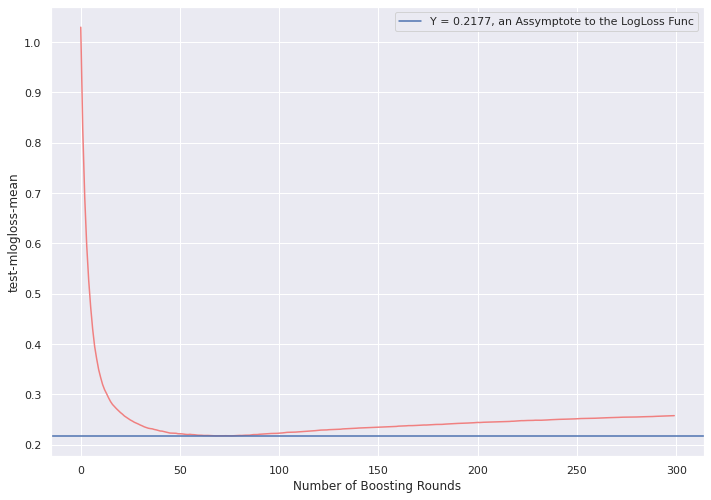

In [ ]:
#Plotting the LogLoss
#The Prediction for the Log Loss of a varible at random is 1.38, since our value is 0.06 we are better than randomness
#Important to note that the probailities are not 25% each but still a great performance nonetheless,
results['test-mlogloss-mean']

sns.lineplot(data=results['test-mlogloss-mean'].iloc[:300],color = "lightcoral")
plt.xlabel('Number of Boosting Rounds')
plt.axhline(y = 0.21773905215850192, color = 'b', linestyle = '-',label='Y = 0.2177, an Assymptote to the LogLoss Func')
plt.legend()
results['test-mlogloss-mean'].min()

What Can we do next? We can look at what are the distribution of the returns using the prediction and compare it to the mean returns of AUDEUR pair which is the best performing usually. 


How do we do this:

1. We use the predicted highest performing Currency Pairs to contruct the Carry Trades for every period 
2. We plot the results 



In [73]:
n = 80

params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": 4}

model = xgb.train(

   params=params,

   dtrain=dtrain_clf,

   num_boost_round=n,

)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

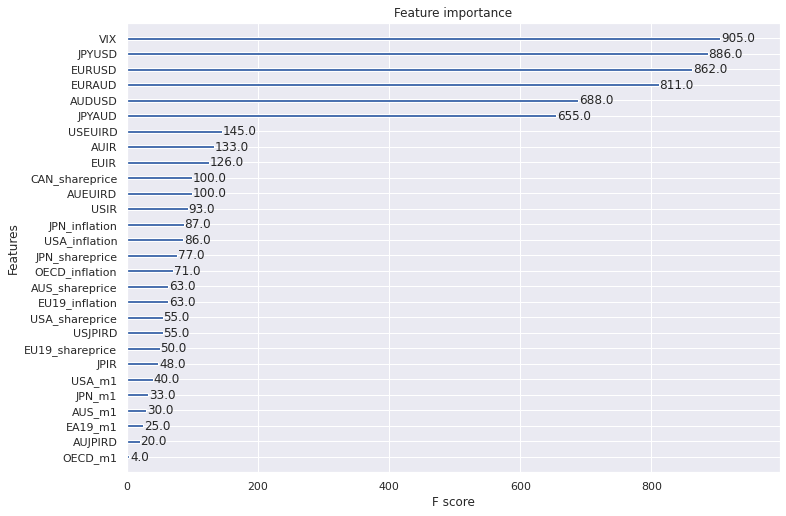

In [75]:
from xgboost import plot_importance
plot_importance(model, )


In [77]:
preds = model.predict(dtest_clf)
predictions = []
for i in preds:
  predictions.append(max(range(len(i)), key=i.__getitem__))


In [78]:
finalTestDf = X_test.copy()
finalTestDf["Actual Values"] = y_test
finalTestDf["Prediction"] = predictions
finalTestDf["Prediction Names"] = le.inverse_transform(predictions)

finalTestDf["difference"] =  np.where(finalTestDf["Actual Values"]==finalTestDf["Prediction"], 1, 0)
finalTestDf.difference.value_counts()

0    771
1    337
Name: difference, dtype: int64

In [79]:

dfResults = pd.merge(finalTestDf, df_total[['CarryJPYAUD','CarryUSDEUR',"CarryJPYUSD","CarryAUDEUR"]], left_index=True, right_index=True)
dfResults.head()

,VIX,EURUSD,JPYUSD,AUDUSD,EURAUD,JPYAUD,AUIR,EUIR,JPIR,USIR,...,OECD_m1,EA19_m1,Actual Values,Prediction,Prediction Names,difference,CarryJPYAUD,CarryUSDEUR,CarryJPYUSD,CarryAUDEUR
2015-06-19,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,99.92637,100.297,1,1,CarryJPYAUD,1,0.266515,0.012609,-0.093707,-0.276029
2015-06-20,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,99.92637,100.297,1,1,CarryJPYAUD,1,0.266515,0.012609,-0.093707,-0.276029
2015-06-21,13.96,1.137074,123.001999,0.778998,1.459662,157.897668,1.005332,0.999965,1.000422,1.00045,...,99.92637,100.297,1,1,CarryJPYAUD,1,0.266515,0.012609,-0.093707,-0.276029
2015-06-22,12.74,1.137294,122.750999,0.776578,1.464494,158.066468,1.005332,0.999965,1.000422,1.00045,...,99.92637,100.297,1,1,CarryJPYAUD,1,0.258953,-0.026356,-0.087495,-0.234190
2015-06-23,12.11,1.134906,123.378998,0.772857,1.468455,159.640086,1.005332,0.999965,1.000422,1.00045,...,99.92637,100.297,1,1,CarryJPYAUD,1,0.271379,-0.053094,-0.091112,-0.223270


In [80]:
def ReturnsPrediction(row):
  if row['Prediction Names'] == "CarryUSDEUR" :
      return row["CarryUSDEUR"]
  if row['Prediction Names'] == "CarryJPYAUD" :
      return row["CarryJPYAUD"]
  if row['Prediction Names'] == "CarryJPYUSD" :
      return row["CarryJPYUSD"]
  if row['Prediction Names'] == "CarryAUDEUR" :
      return row["CarryAUDEUR"]
                 
dfResults["Model Returns"] = dfResults.apply(lambda x: ReturnsPrediction(x), axis=1)

In [81]:
dfResults.loc[dfResults["Model Returns"].idxmin()]

VIX                       19.34
EURUSD                 1.082755
JPYUSD               119.467003
AUDUSD                 0.718597
EURAUD                 1.506762
JPYAUD               166.250282
AUIR                   1.005701
EUIR                   0.999635
JPIR                   1.000422
USIR                   1.001422
AUJPIRD                0.005263
AUEUIRD                 0.00605
USJPIRD                0.000999
USEUIRD                0.001786
JPN_inflation              -0.1
USA_inflation          1.373087
OECD_inflation         1.286163
EU19_inflation              0.4
AUS_shareprice         90.90173
CAN_shareprice         86.42041
JPN_shareprice         91.55745
USA_shareprice         89.20781
EU19_shareprice        90.36546
AUS_m1                 106.2783
JPN_m1                 102.3897
USA_m1                 102.4873
OECD_m1                104.2861
EA19_m1                105.3134
Actual Values                 3
Prediction                    1
Prediction Names    CarryJPYAUD
differen

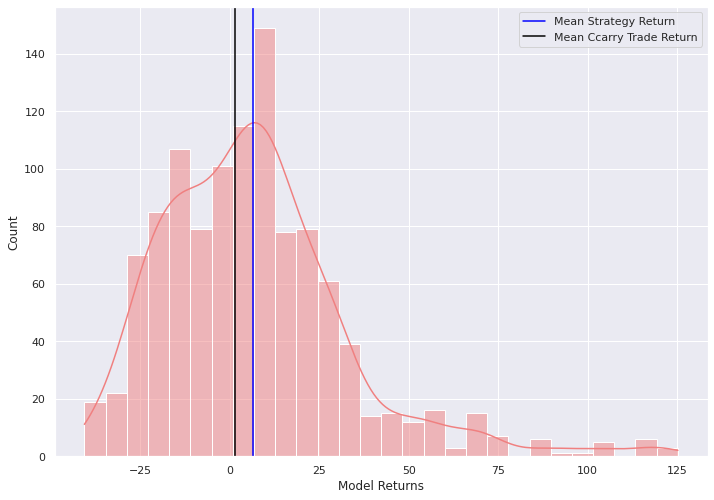

In [82]:
dfResults["Mean Return"] = dfResults[['CarryJPYAUD','CarryUSDEUR',"CarryJPYUSD","CarryAUDEUR"]].mean(axis=1)*100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=dfResults["Model Returns"]*100,color = "lightcoral",kde = True)
plt.axvline(x=dfResults["Model Returns"].mean()*100, color='blue',label = "Mean Strategy Return")
plt.axvline(x=dfResults["Mean Return"].mean(), color='black',label = "Mean Carry Trade Return")
plt.legend()

In [89]:
list_returns = [dfResults["Model Returns"].mean()*100,
dfResults["CarryJPYAUD"].mean()*100,
dfResults["CarryUSDEUR"].mean()*100,
dfResults["CarryJPYUSD"].mean()*100,
dfResults["CarryAUDEUR"].mean()*100]
list_returns

[6.642718892197622,
 2.275104480134417,
 3.6086115534427754,
 -0.7032776649828772,
 1.2582832062130582]

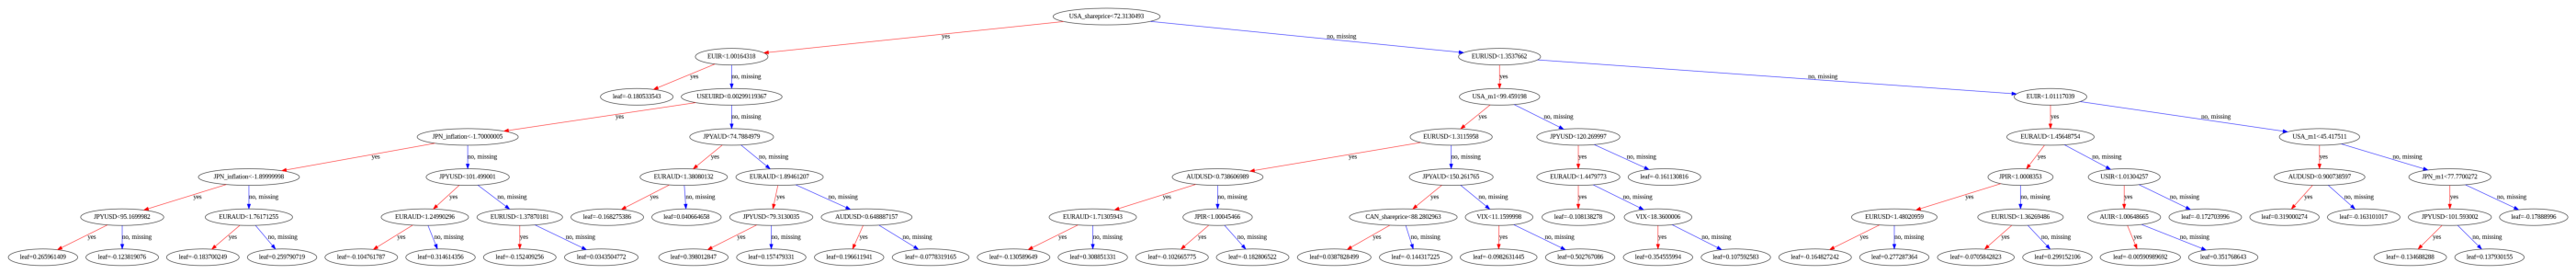

In [84]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots(figsize=(50, 50))
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()